### This code deals with the following:

- missing price imputation
- any processing to convert numeric values
    - convert count of stars to percentage
    - TF-IDF the one-hot encoded columns
    - standardization of ratings by user
    - dropping duplicate reviews to most recent user


In [2]:
%matplotlib inline
import os, sys, time, math
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt

from scipy import sparse, stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [9]:
b = pd.read_csv("business_partial.csv")

In [10]:
b[b.city.isin(["Las Vegas", "Phoenix"])].shape

(14776, 45)

In [13]:
b[b.city.isin(["Las Vegas", "Phoenix"])].isnull().sum() / b[b.city.isin(["Las Vegas", "Phoenix"])].shape[0]

business_id                 0.000000
name                        0.000000
city                        0.000000
stars                       0.000000
price                       0.210409
review_count                0.000000
1star_counts                0.000000
2star_counts                0.000000
3star_counts                0.000000
4star_counts                0.000000
5star_counts                0.000000
text                        0.000000
text_friendly               0.000000
text_reasonable             0.000000
text_local                  0.000000
text_comfortable            0.000000
text_easy                   0.000000
text_quick                  0.000000
categories                  0.000000
categories_clean            0.000000
cat_Restaurants             0.000000
cat_Food                    0.000000
cat_Shopping                0.000000
cat_Active Life             0.000000
cat_Arts & Entertainment    0.000000
cat_Nightlife               0.000000
cat_Hotels & Travel         0.000000
c

In [3]:
# load pre-filtered data
'''
This data has ben filtered by:
- Open businesses only
- Top 5 cities
- Have 1 in either cat_Restaurants or cat_Food

This data has been preprocessed to:
- Include count of reviews
- Perceptual features
- Categories one-hot encode
'''

b = pd.read_csv('business_r_and_f.csv', index_col='business_id')
print(b.shape)

(18504, 204)


In [7]:
b[b.city.isin(["Las Vegas", "Phoenix"])].shape

(8329, 204)

In [8]:
b[b.city.isin(["Las Vegas", "Phoenix"])].isnull().sum() / b[b.city.isin(["Las Vegas", "Phoenix"])].shape[0]

name                        0.000000
city                        0.000000
las_vegas                   0.000000
stars                       0.000000
price                       0.054869
review_count                0.000000
1star_counts                0.000000
2star_counts                0.000000
3star_counts                0.000000
4star_counts                0.000000
5star_counts                0.000000
text                        0.000000
word_count                  0.000000
text_friendly               0.000000
text_reasonable             0.000000
text_local                  0.000000
text_comfortable            0.000000
text_easy                   0.000000
text_quick                  0.000000
cat_Restaurants             0.000000
cat_Food                    0.000000
cat_Shopping                0.000000
cat_Active Life             0.000000
cat_Arts & Entertainment    0.000000
cat_Nightlife               0.000000
cat_Hotels & Travel         0.000000
cat_Tours                   0.000000
c

### Business - convert star counts to percentage

In [179]:
[col for col in b.columns]

['name',
 'city',
 'las_vegas',
 'stars',
 'price',
 'review_count',
 '1star_counts',
 '2star_counts',
 '3star_counts',
 '4star_counts',
 '5star_counts',
 'text',
 'word_count',
 'text_friendly',
 'text_reasonable',
 'text_local',
 'text_comfortable',
 'text_easy',
 'text_quick',
 'cat_Restaurants',
 'cat_Food',
 'cat_Shopping',
 'cat_Active Life',
 'cat_Arts & Entertainment',
 'cat_Nightlife',
 'cat_Hotels & Travel',
 'cat_Tours',
 'cat_Landmark',
 'cat_Others',
 'state',
 'address',
 'neighborhood',
 'postal_code',
 'latitude',
 'longitude',
 'monday',
 'tuesday',
 'wednesday',
 'thursday',
 'friday',
 'saturday',
 'sunday',
 'Acai Bowls',
 'Afghan',
 'African',
 'American (New)',
 'American (Traditional)',
 'Arcades',
 'Asian Fusion',
 'Bagels',
 'Bakeries',
 'Barbeque',
 'Bars',
 'Bed & Breakfast',
 'Beer',
 'Beer Bar',
 'Bistros',
 'Brasseries',
 'Brazilian',
 'Breakfast & Brunch',
 'Breweries',
 'British',
 'Bubble Tea',
 'Buffets',
 'Burgers',
 'Butcher',
 'Cafes',
 'Cajun/Creol

In [180]:
b['1star_counts'] = b['1star_counts']/b['review_count']
b['2star_counts'] = b['2star_counts']/b['review_count']
b['3star_counts'] = b['3star_counts']/b['review_count']
b['4star_counts'] = b['4star_counts']/b['review_count']
b['5star_counts'] = b['5star_counts']/b['review_count']
b.head()

,name,city,las_vegas,stars,price,review_count,1star_counts,2star_counts,3star_counts,4star_counts,...,Thai,Turkish,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Waffles,Wine & Spirits,Wine Bars,Wraps
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,Las Vegas,1,4.0,4.0,1546,0.032988,0.088616,0.113842,0.271669,...,0,0,0,0,0,0,0,0,0,0
--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,0,3.5,2.0,45,0.088889,0.066667,0.200000,0.355556,...,0,0,0,0,0,0,0,0,0,0
--KCl2FvVQpvjzmZSPyviA,Hungry Howie's Pizza,Charlotte,0,3.0,1.0,13,0.230769,0.153846,0.230769,0.076923,...,0,0,0,0,0,0,0,0,0,0
--cZ6Hhc9F7VkKXxHMVZSQ,Pio Pio,Charlotte,0,4.0,2.0,333,0.066066,0.066066,0.129129,0.333333,...,0,0,0,0,0,0,0,0,0,0
-01XupAWZEXbdNbxNg5mEg,18 Degrees Neighborhood Grill,Scottsdale,0,3.0,2.0,82,0.243902,0.170732,0.207317,0.268293,...,0,0,0,0,0,0,0,0,0,0


In [181]:
# rename star counts to star ratio

col_rename = {
    '1star_counts': '1star_ratio',
    '2star_counts': '2star_ratio',
    '3star_counts': '3star_ratio',
    '4star_counts': '4star_ratio',
    '5star_counts': '5star_ratio'
    }

b.rename(col_rename, axis=1, inplace=True)

b.head()

,name,city,las_vegas,stars,price,review_count,1star_ratio,2star_ratio,3star_ratio,4star_ratio,...,Thai,Turkish,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Waffles,Wine & Spirits,Wine Bars,Wraps
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,Las Vegas,1,4.0,4.0,1546,0.032988,0.088616,0.113842,0.271669,...,0,0,0,0,0,0,0,0,0,0
--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,0,3.5,2.0,45,0.088889,0.066667,0.200000,0.355556,...,0,0,0,0,0,0,0,0,0,0
--KCl2FvVQpvjzmZSPyviA,Hungry Howie's Pizza,Charlotte,0,3.0,1.0,13,0.230769,0.153846,0.230769,0.076923,...,0,0,0,0,0,0,0,0,0,0
--cZ6Hhc9F7VkKXxHMVZSQ,Pio Pio,Charlotte,0,4.0,2.0,333,0.066066,0.066066,0.129129,0.333333,...,0,0,0,0,0,0,0,0,0,0
-01XupAWZEXbdNbxNg5mEg,18 Degrees Neighborhood Grill,Scottsdale,0,3.0,2.0,82,0.243902,0.170732,0.207317,0.268293,...,0,0,0,0,0,0,0,0,0,0


### Business - missing price imputation using text

In [182]:
# examine the average price across cities
b.groupby('city')['stars', 'price'].agg(['mean'])

,stars,price
,mean,mean
city,,
Charlotte,3.464536,1.566905
Las Vegas,3.491629,1.592363
Phoenix,3.480474,1.459201
Scottsdale,3.682259,1.727273
Toronto,3.482696,1.794073


In [183]:
# split train and test indices
X_train = b.text[b.price.notnull()]
y_train = b.price[b.price.notnull()]
X_test = b.text[b.price.isnull()]

In [184]:
# use HashingVectorizer for efficiency
vectorizer = HashingVectorizer(stop_words='english', n_features=100, non_negative=True)
vectorizer.fit(X_train)

X_train_dtm = vectorizer.fit_transform(X_train)
X_train_dtm

C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


<17131x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1629236 stored elements in Compressed Sparse Row format>

In [185]:
X_test_dtm = vectorizer.transform(X_test)
X_test_dtm

C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


<1373x100 sparse matrix of type '<class 'numpy.float64'>'
	with 103658 stored elements in Compressed Sparse Row format>

In [186]:
# fit Nultinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [187]:
y_pred = nb.predict(X_test_dtm)
y_pred.shape

(1373,)

In [188]:
unique, counts = np.unique([int(price) for price in y_pred], return_counts=True)
print(np.asarray((unique, counts)).T)

[[   1  181]
 [   2 1192]]


In [189]:
b.price[b.price.isnull()] = y_pred
b.price

C:\Users\mm4me\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


business_id
--9e1ONYQuAa-CB_Rrw7Tw    4.0
--DaPTJW3-tB1vP-PfdTEg    2.0
--KCl2FvVQpvjzmZSPyviA    1.0
--cZ6Hhc9F7VkKXxHMVZSQ    2.0
-01XupAWZEXbdNbxNg5mEg    2.0
-0BxAGlIk5DJAGVkpqBXxg    2.0
-0QtTRrAMn6DKLZNef3Ojg    1.0
-0WegMt6Cy966qlDKhu6jA    2.0
-0aOudcaAyac0VJbMX-L1g    1.0
-0tgMGl7D9B10YjSN2ujLA    2.0
-1UMR00eXtwaeh59pEiDjA    2.0
-1m9o3vGRA8IBPNvNqKLmA    4.0
-1uVyyy3UXNA9WoPucNniA    1.0
-2isRNVb6PDuBagELL5EBw    1.0
-2pQf1ceDZyE2ReCNbj-3A    1.0
-2pmn-oTJeybmDrL-ojwrw    1.0
-2uYjztVuVZpkTNAC38zdg    1.0
-3VEk6j5XnEnOOthoY2jYQ    1.0
-3iE3lPp18Tn2ixqIRJB_w    2.0
-3pJJf-vHQfysafL0r8YsA    1.0
-3vXcKzJA_kVZDM8Yn3w_Q    2.0
-3zffZUHoY8bQjGfPSoBKQ    4.0
-45kMvS7h38CGaWugPY0rg    2.0
-46pFijv3f2jZH-_Ze6CQA    4.0
-4TMQnQJW1yd6NqGRDvAeA    3.0
-4eA7Um2eiOKsGLmcXNx_w    2.0
-4uT6QFVaRtc2Zmxvtd9Vg    2.0
-5L8zOxibac-vBrsYtxXbQ    2.0
-6h3K1hj0d4DRcZNUtHDuw    2.0
-6sE5v4OrVGmWxdIrbs-RQ    2.0
                         ... 
zsgvTFimYf4stONAJOyePw    2.0
zsl5aN9J7gTu_s3UVVJ8aQ    1.

In [10]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(b['text'][:5])
X

<5x20 sparse matrix of type '<class 'numpy.float64'>'
	with 84 stored elements in Compressed Sparse Row format>

In [22]:
print(X.get_shape())
print(b.shape)

(18504, 560378)
(18504, 205)


In [24]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(X)
print(svd.explained_variance_ratio_.sum())

0.3983546741552358


### Business - drop columns and normalize numerical

In [190]:
# drop columns that are zero
b.drop(['cat_Landmark', 'cat_Others'], axis=1, inplace=True)

In [191]:
[col for col in b.columns]

['name',
 'city',
 'las_vegas',
 'stars',
 'price',
 'review_count',
 '1star_ratio',
 '2star_ratio',
 '3star_ratio',
 '4star_ratio',
 '5star_ratio',
 'text',
 'word_count',
 'text_friendly',
 'text_reasonable',
 'text_local',
 'text_comfortable',
 'text_easy',
 'text_quick',
 'cat_Restaurants',
 'cat_Food',
 'cat_Shopping',
 'cat_Active Life',
 'cat_Arts & Entertainment',
 'cat_Nightlife',
 'cat_Hotels & Travel',
 'cat_Tours',
 'state',
 'address',
 'neighborhood',
 'postal_code',
 'latitude',
 'longitude',
 'monday',
 'tuesday',
 'wednesday',
 'thursday',
 'friday',
 'saturday',
 'sunday',
 'Acai Bowls',
 'Afghan',
 'African',
 'American (New)',
 'American (Traditional)',
 'Arcades',
 'Asian Fusion',
 'Bagels',
 'Bakeries',
 'Barbeque',
 'Bars',
 'Bed & Breakfast',
 'Beer',
 'Beer Bar',
 'Bistros',
 'Brasseries',
 'Brazilian',
 'Breakfast & Brunch',
 'Breweries',
 'British',
 'Bubble Tea',
 'Buffets',
 'Burgers',
 'Butcher',
 'Cafes',
 'Cajun/Creole',
 'Canadian (New)',
 'Candy Stores

In [192]:
business_features = [
 'stars',
 'price',
 'review_count',
 '1star_ratio',
 '2star_ratio',
 '3star_ratio',
 '4star_ratio',
 '5star_ratio',
 'word_count',
 'text_friendly',
 'text_reasonable',
 'text_local',
 'text_comfortable',
 'text_easy',
 'text_quick',
 'cat_Restaurants',
 'cat_Food',
 'cat_Shopping',
 'cat_Active Life',
 'cat_Arts & Entertainment',
 'cat_Nightlife',
 'cat_Hotels & Travel',
 'cat_Tours'
]

b[business_features].describe()

,stars,price,review_count,1star_ratio,2star_ratio,3star_ratio,4star_ratio,5star_ratio,word_count,text_friendly,...,text_easy,text_quick,cat_Restaurants,cat_Food,cat_Shopping,cat_Active Life,cat_Arts & Entertainment,cat_Nightlife,cat_Hotels & Travel,cat_Tours
count,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,...,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000,18504.000000
mean,3.494596,1.660560,105.563013,0.174362,0.099019,0.137866,0.236334,0.352398,99.602346,0.113102,...,0.020033,0.047642,0.781128,0.514754,0.032425,0.004053,0.016645,0.127270,0.005404,0.001675
std,0.826648,0.614678,246.331886,0.186000,0.097856,0.116496,0.145424,0.238323,31.071554,0.109016,...,0.043585,0.067366,0.413493,0.499796,0.177132,0.063537,0.127941,0.333284,0.073317,0.040897
min,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.666667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,10.000000,0.038701,0.025000,0.060176,0.142857,0.166667,80.233865,0.033898,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.500000,2.000000,32.000000,0.112903,0.081286,0.121951,0.236559,0.333333,96.049524,0.095165,...,0.000000,0.030704,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,100.000000,0.250000,0.142857,0.192308,0.329677,0.500000,114.263311,0.161290,...,0.024390,0.066057,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,4.000000,7968.000000,1.000000,1.000000,1.000000,1.000000,1.125000,520.500000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Explore the following transformations:
    - Log
    - StandardScaler
    - MinMaxScaler

In [193]:
scaler = StandardScaler()
minmax = MinMaxScaler()

count    18504.000000
mean       105.563013
std        246.331886
min          3.000000
25%         10.000000
50%         32.000000
75%        100.000000
max       7968.000000
Name: review_count, dtype: float64

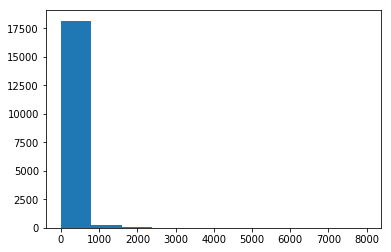

In [194]:
# examine review_count
plt.hist(b.review_count)
b.review_count.describe()

count    18504.000000
mean         3.594165
std          1.429847
min          1.386294
25%          2.397895
50%          3.496508
75%          4.615121
max          8.983314
dtype: float64


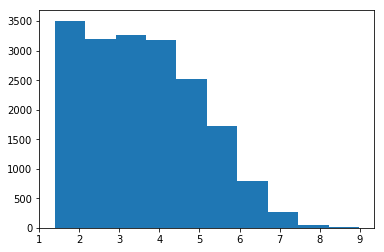

In [195]:
# examine log review_count
plt.hist(pd.Series([math.log(x+1) for x in b.review_count]))
print(pd.Series([math.log(x+1) for x in b.review_count]).describe())

DescribeResult(nobs=18504, minmax=(array([-0.41637234]), array([31.91892684])), mean=array([3.83994129e-19]), variance=array([1.00005405]), skewness=array([10.13539868]), kurtosis=array([197.58280952]))


C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


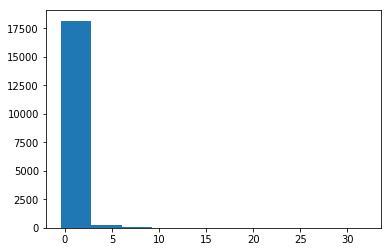

In [196]:
# examine scaled review_count
plt.hist(scaler.fit_transform(np.array(b.review_count).reshape(-1,1)))
print(stats.describe(scaler.fit_transform(np.array(b.review_count).reshape(-1,1))))

C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


DescribeResult(nobs=18504, minmax=(array([0.]), array([1.])), mean=array([0.01287671]), variance=array([0.00095647]), skewness=array([10.13539868]), kurtosis=array([197.58280952]))


C:\Users\mm4me\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


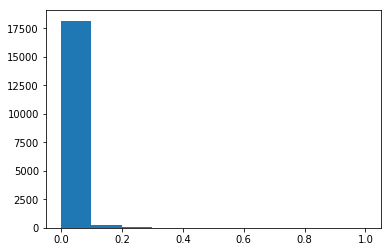

In [197]:
# examine minmax review_count
plt.hist(minmax.fit_transform(np.array(b.review_count).reshape(-1,1)))
print(stats.describe(minmax.fit_transform(np.array(b.review_count).reshape(-1,1))))

In [198]:
# log review_count
b["review_count"] = [math.log(x+1) for x in b.review_count]

In [199]:
b.head()

,name,city,las_vegas,stars,price,review_count,1star_ratio,2star_ratio,3star_ratio,4star_ratio,...,Thai,Turkish,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Waffles,Wine & Spirits,Wine Bars,Wraps
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,Las Vegas,1,4.0,4.0,7.344073,0.032988,0.088616,0.113842,0.271669,...,0,0,0,0,0,0,0,0,0,0
--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,0,3.5,2.0,3.828641,0.088889,0.066667,0.200000,0.355556,...,0,0,0,0,0,0,0,0,0,0
--KCl2FvVQpvjzmZSPyviA,Hungry Howie's Pizza,Charlotte,0,3.0,1.0,2.639057,0.230769,0.153846,0.230769,0.076923,...,0,0,0,0,0,0,0,0,0,0
--cZ6Hhc9F7VkKXxHMVZSQ,Pio Pio,Charlotte,0,4.0,2.0,5.811141,0.066066,0.066066,0.129129,0.333333,...,0,0,0,0,0,0,0,0,0,0
-01XupAWZEXbdNbxNg5mEg,18 Degrees Neighborhood Grill,Scottsdale,0,3.0,2.0,4.418841,0.243902,0.170732,0.207317,0.268293,...,0,0,0,0,0,0,0,0,0,0


#### word_count

count    18504.000000
mean        99.602346
std         31.071554
min         20.666667
25%         80.233865
50%         96.049524
75%        114.263311
max        520.500000
Name: word_count, dtype: float64

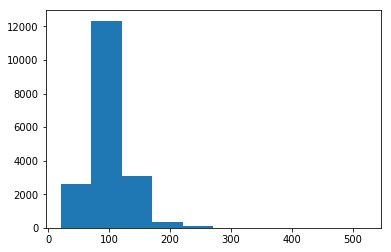

In [200]:
# examine word_count
plt.hist(b.word_count)
b.word_count.describe()

count    18504.000000
mean         4.566147
std          0.302522
min          3.075775
25%          4.397332
50%          4.575221
75%          4.747219
max          6.256709
dtype: float64


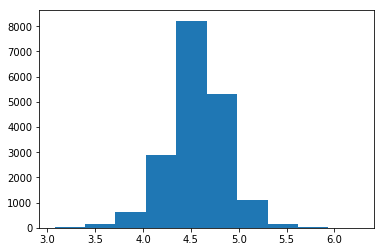

In [201]:
# examine log word_count
plt.hist(pd.Series([math.log(x+1) for x in b.word_count]))
print(pd.Series([math.log(x+1) for x in b.word_count]).describe())

In [202]:
# log word_count
b.word_count = [math.log(x+1) for x in b.word_count]

In [203]:
b.head()

,name,city,las_vegas,stars,price,review_count,1star_ratio,2star_ratio,3star_ratio,4star_ratio,...,Thai,Turkish,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Waffles,Wine & Spirits,Wine Bars,Wraps
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,Las Vegas,1,4.0,4.0,7.344073,0.032988,0.088616,0.113842,0.271669,...,0,0,0,0,0,0,0,0,0,0
--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,0,3.5,2.0,3.828641,0.088889,0.066667,0.200000,0.355556,...,0,0,0,0,0,0,0,0,0,0
--KCl2FvVQpvjzmZSPyviA,Hungry Howie's Pizza,Charlotte,0,3.0,1.0,2.639057,0.230769,0.153846,0.230769,0.076923,...,0,0,0,0,0,0,0,0,0,0
--cZ6Hhc9F7VkKXxHMVZSQ,Pio Pio,Charlotte,0,4.0,2.0,5.811141,0.066066,0.066066,0.129129,0.333333,...,0,0,0,0,0,0,0,0,0,0
-01XupAWZEXbdNbxNg5mEg,18 Degrees Neighborhood Grill,Scottsdale,0,3.0,2.0,4.418841,0.243902,0.170732,0.207317,0.268293,...,0,0,0,0,0,0,0,0,0,0


#### stars

4.0    4657
3.5    4228
3.0    2955
4.5    2497
2.5    1828
2.0    1091
5.0     734
1.5     401
1.0     113
Name: stars, dtype: int64

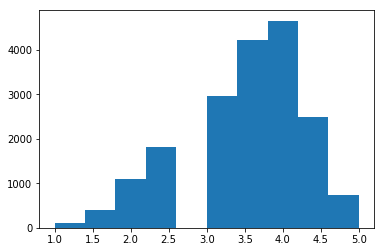

In [90]:
# examine stars
plt.hist(b.stars)
b.stars.value_counts()

#### price

2.0    9915
1.0    7524
3.0     887
4.0     178
Name: price, dtype: int64

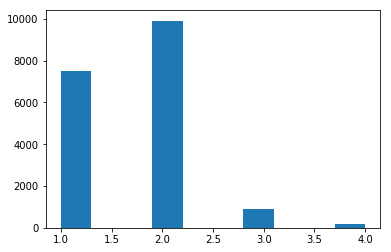

In [89]:
# examine price
plt.hist(b.price)
b.price.value_counts()

#### 1star_ratio

count    18504.000000
mean         0.174362
std          0.186000
min          0.000000
25%          0.038701
50%          0.112903
75%          0.250000
max          1.000000
Name: 1star_ratio, dtype: float64

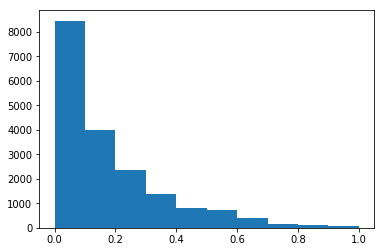

In [92]:
# examine 1star_ratio
plt.hist(b['1star_ratio'])
b['1star_ratio'].describe()

count    18504.000000
mean         0.286757
std          0.173143
min          0.000000
25%          0.154151
50%          0.287682
75%          0.405465
max          0.753772
dtype: float64


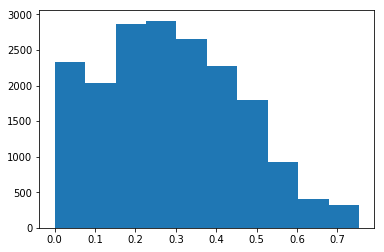

In [106]:
# examine log 1star_ratio
plt.hist(pd.Series([math.log(x+1) for x in b['5star_ratio']]))
print(pd.Series([math.log(x+1) for x in b['5star_ratio']]).describe())

DescribeResult(nobs=18504, minmax=(array([-1.47869529]), array([3.24191092])), mean=array([4.83832602e-17]), variance=array([1.00005405]), skewness=array([0.54288604]), kurtosis=array([-0.21417411]))


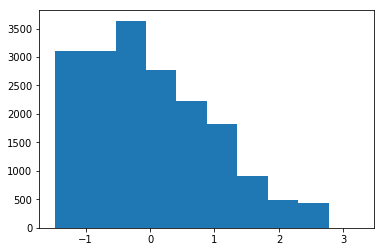

In [107]:
# examine scaled 1star_ratio
plt.hist(scaler.fit_transform(np.array(b['5star_ratio']).reshape(-1,1)))
print(stats.describe(scaler.fit_transform(np.array(b['5star_ratio']).reshape(-1,1))))

DescribeResult(nobs=18504, minmax=(array([0.]), array([1.])), mean=array([0.31324267]), variance=array([0.04487742]), skewness=array([0.54288604]), kurtosis=array([-0.21417411]))


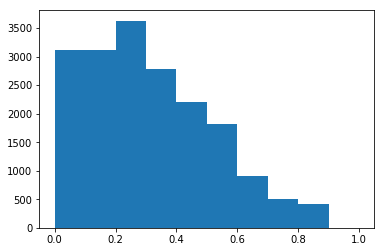

In [108]:
# examine minmax 1star_ratio
plt.hist(minmax.fit_transform(np.array(b['5star_ratio']).reshape(-1,1)))
print(stats.describe(minmax.fit_transform(np.array(b['5star_ratio']).reshape(-1,1))))

#### text_friendly

In [118]:
print(b[b.text_comfortable > 0].shape[0]/b.shape[0])
print(b[b.text_easy > 0].shape[0]/b.shape[0])
print(b[b.text_friendly > 0].shape[0]/b.shape[0])
print(b[b.text_local > 0].shape[0]/b.shape[0])
print(b[b.text_quick > 0].shape[0]/b.shape[0])
print(b[b.text_reasonable > 0].shape[0]/b.shape[0])

0.2996649373108517
0.4718979680069174
0.7852356247297881
0.4301772589710333
0.6374297449200172
0.4474708171206226


count    18504.000000
mean         0.113102
std          0.109016
min          0.000000
25%          0.033898
50%          0.095165
75%          0.161290
max          1.000000
Name: text_friendly, dtype: float64


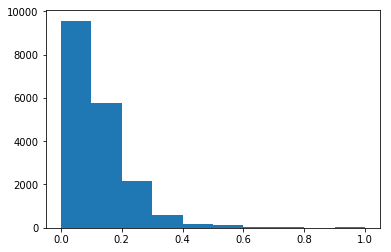

In [112]:
# examine text_friendly
plt.hist(b['text_friendly'])
print(b['text_friendly'].describe())

count    18504.000000
mean         0.102795
std          0.091344
min          0.000000
25%          0.033336
50%          0.090905
75%          0.149532
max          0.693147
dtype: float64


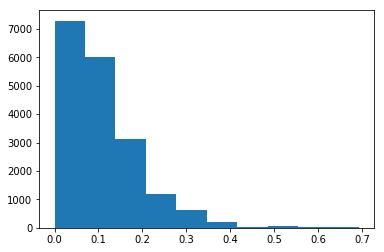

In [109]:
# examine log text_friendly
plt.hist(pd.Series([math.log(x+1) for x in b['text_friendly']]))
print(pd.Series([math.log(x+1) for x in b['text_friendly']]).describe())

DescribeResult(nobs=18504, minmax=(array([-1.03751124]), array([8.13573711])), mean=array([-1.91997064e-17]), variance=array([1.00005405]), skewness=array([1.96523917]), kurtosis=array([7.68852365]))


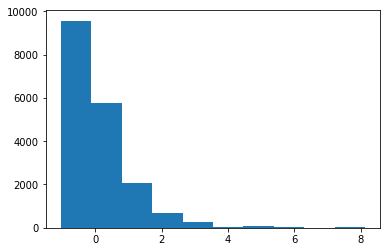

In [110]:
# examine scaled text_friendly
plt.hist(scaler.fit_transform(np.array(b['text_friendly']).reshape(-1,1)))
print(stats.describe(scaler.fit_transform(np.array(b['text_friendly']).reshape(-1,1))))

DescribeResult(nobs=18504, minmax=(array([0.]), array([1.])), mean=array([0.11310184]), variance=array([0.0118844]), skewness=array([1.96523917]), kurtosis=array([7.68852365]))


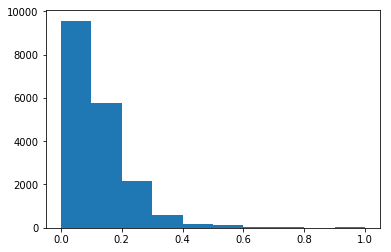

In [111]:
# examine minmax text_friendly
plt.hist(minmax.fit_transform(np.array(b['text_friendly']).reshape(-1,1)))
print(stats.describe(minmax.fit_transform(np.array(b['text_friendly']).reshape(-1,1))))

In [124]:
b.head()

,name,city,las_vegas,stars,price,review_count,1star_ratio,2star_ratio,3star_ratio,4star_ratio,...,Thai,Turkish,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Waffles,Wine & Spirits,Wine Bars,Wraps
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,Las Vegas,1,4.0,4.0,NaN,0.032988,0.088616,0.113842,0.271669,...,0,0,0,0,0,0,0,0,0,0
--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,0,3.5,2.0,NaN,0.088889,0.066667,0.200000,0.355556,...,0,0,0,0,0,0,0,0,0,0
--KCl2FvVQpvjzmZSPyviA,Hungry Howie's Pizza,Charlotte,0,3.0,1.0,NaN,0.230769,0.153846,0.230769,0.076923,...,0,0,0,0,0,0,0,0,0,0
--cZ6Hhc9F7VkKXxHMVZSQ,Pio Pio,Charlotte,0,4.0,2.0,NaN,0.066066,0.066066,0.129129,0.333333,...,0,0,0,0,0,0,0,0,0,0
-01XupAWZEXbdNbxNg5mEg,18 Degrees Neighborhood Grill,Scottsdale,0,3.0,2.0,NaN,0.243902,0.170732,0.207317,0.268293,...,0,0,0,0,0,0,0,0,0,0


In [204]:
# save business dataset
b.to_csv('business_r_and_f_8.4.csv')

### User

In [121]:
u = pd.read_csv('user_r_and_f', index_col='user_id')
print(u.shape)

(654161, 22)


In [122]:
u.head()

,name,review_count,average_stars,yelping_since,friends,fans,elite,cool,funny,useful,...,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,friend_count
user_id,,,,,,,,,,,,,,,,,,,,,
lzlZwIpuSWXEnNS91wxjHw,Susan,1,2.00,2015-09-28,None,0,None,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XvLBr-9smbI0m_a7dXtB7w,Daipayan,2,5.00,2015-09-05,None,0,None,0,0,0,...,0,0,0,0,0,0,0,0,0,0
QPT4Ud4H5sJVr68yXhoWFw,Andy,1,4.00,2016-07-21,None,0,None,0,0,0,...,0,0,0,0,0,0,0,0,0,0
s4FoIXE_LSGviTHBe8dmcg,Shashank,3,3.00,2017-06-18,None,0,None,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nnB0AE1Cxp_0154xkhXelw,Mike,11,2.77,2014-07-11,None,1,None,0,0,8,...,0,0,0,0,0,0,0,0,0,0


In [123]:
[col for col in u.columns]

['name',
 'review_count',
 'average_stars',
 'yelping_since',
 'friends',
 'fans',
 'elite',
 'cool',
 'funny',
 'useful',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'friend_count']

### Review - delete duplicate reviews

In [36]:
r = pd.read_csv('review_r_and_f')
print(r.shape)

(1953249, 9)


In [37]:
r.sample(5)

,review_id,business_id,cool,date,funny,stars,text,useful,user_id
368310,Tv_K6XzCGFXHc_TnwSSRqg,FXiPQQGr_2bwlJ4wOrW2eA,0,2018-04-18,0,2,Not impressed at all. Bread was cold and bland...,1,0wH8fLJ5upPqExGx5GkwCA
265565,HfCNzlLpBwQ4HY04p43xDA,G03yt8WuN1v0bCD8mvoDiA,1,2017-05-17,0,5,"If you're looking for a great sub, this is the...",3,tT4FR1IFaKefW2hwOSRCxQ
1281217,G24vdV1jT41U3HafC3vXHg,966W5oXOBW0ZWhNYy0yjcA,0,2015-06-26,0,5,Wendy's noodle shop is an unassuming little Ch...,1,Zw-0Lo01W0QdkHT60DYg4g
757946,Va3N_193RGZJILhBl-Huxw,0NmTwqYEQiKErDv4a55obg,0,2015-06-30,0,1,Waiter was unfriendly and not welcoming. Wa...,1,x_YWFkTcxEu1lo8Nlrog5A
177762,vH7aOl2HAOA6VchEkhQhSQ,e9sB72njxz87r5TL6kG-Fw,2,2017-01-12,2,4,I've had a few tasty lunches at Cowbell. I've ...,2,ivyst1KduPZspC77zavZsQ


In [40]:
r_count = r.groupby(['business_id', 'user_id'])['review_id'].size().reset_index(name='counts')
r_count.head()

,business_id,user_id,counts
0,--9e1ONYQuAa-CB_Rrw7Tw,---1lKK3aKOuomHnwAkAow,1
1,--9e1ONYQuAa-CB_Rrw7Tw,-11nMat3F0DgsxT30hn8zA,1
2,--9e1ONYQuAa-CB_Rrw7Tw,-3fMaL_ck0wzEsTZyz-mqA,1
3,--9e1ONYQuAa-CB_Rrw7Tw,-47EprTYhe9IbAvplGIcpA,1
4,--9e1ONYQuAa-CB_Rrw7Tw,-7cPERHtAupd1Xq53nmhXg,1


In [42]:
# check if there are duplicate reviews of the same business
r_count.describe()

,counts
count,1953249.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


### Review - standardize star rating to count for bias and make negative to -1 and positive to 1

In [45]:
unique_users = u.index

for i, user in enumerate(unique_users):
    # get average rating
    avg = float(u.average_stars[u.index == user])
    
    # standardize
    sentiment

Index(['lzlZwIpuSWXEnNS91wxjHw', 'XvLBr-9smbI0m_a7dXtB7w',
       'QPT4Ud4H5sJVr68yXhoWFw', 's4FoIXE_LSGviTHBe8dmcg',
       'nnB0AE1Cxp_0154xkhXelw', 'XoEnrhtJc2pcdlQ09d8Oug',
       'QDQTMYp2NocktWN5fHwfIg', 'SgYDjNCecPidsRB_su5-tw',
       'NfE1uHFWzzMyXkgBeEuR1A', 'RiBVI6UgLjfpA4EQ1SWDzA',
       ...
       '60zMHHm6wpOFqCHG4OV81w', 'a8mOFGT4ycNL20TCEFkqaA',
       '69VNRfJ47FgGnGk0Pv8rdw', 'kwQ3BMAx-_cHmfEFH5qTfw',
       'c-cVGZ2nMZykcPIty31ACQ', '3Aw_juO9mTtSr1rfqdA1zA',
       'd2SkpTWNz5K2SW6N7edBDQ', 'dh8Tq0V6cPBYhEL0aIDHLA',
       'WYh5sCrjMuv6liUU48r3Jw', 'dZ-qwZX1_Ge-8KuSIJHhyA'],
      dtype='object', name='user_id', length=654161)

In [46]:
r.groupby('user_id')['stars'].mean()

user_id
---1lKK3aKOuomHnwAkAow    3.777778
---94vtJ_5o_nikEs6hUjg    5.000000
---PLwSf5gKdIoVnyRHgBA    3.000000
---udAKDsn0yQXmzbWQNSw    4.500000
--0WZ5gklOfbUIodJuKfaQ    5.000000
--0sXNBv6IizZXuV-nl0Aw    5.000000
--1mPJZdSY9KluaBYAGboQ    5.000000
--2HUmLkcNHZp0xw6AMBPg    4.724138
--2bpE5vyR-2hAP7sZZ4lA    4.000000
--2vR0DIsmQ6WfcSzKWigw    3.800000
--3WaS23LcIXtxyFULJHTA    3.857143
--3loIEaXcepp9OKGi_1FQ    5.000000
--41c9Tl0C9OGewIR7Qyzg    4.500000
--4q8EyqThydQm-eKZpS-A    2.000000
--4rAAfZnEIAKJE80aIiYg    2.750000
--4uW4yJiRT2oXMYkCPq1Q    4.000000
--5-MQZPsn2CJkyMFQkOgQ    5.000000
--56mD0sm1eOogphi2FFLw    4.500000
--5XzJ2pRsVVJiJUfzZlgQ    5.000000
--66hzx80CeVZcrm4AKJtQ    4.000000
--6Ke7_lBBM6XAramtPoWw    5.000000
--6yF1CPQCVlnFS-sxi7Rg    1.000000
--7gjElmOrthETJ8XqzMBw    3.250000
--7oh57FmI8_IHX0Q4n-Wg    4.000000
--8ELb8W1afbyP21EZStPg    5.000000
--8g9UaBe0xQ4FD0q34h_A    4.000000
--9yZb1OLNN18HyDXgZrJA    4.000000
--AujbGl6SYRaY8SFVNHXA    5.000000
--B6JIfTRS2g

### Normalize/Standardize Numeric Variables

In [13]:
# scale all columns to 0-1
scaler = StandardScaler()

In [14]:
scaler.fit_transform(X)

array([[ 1.62624477,  0.61140662,  3.74791502, ..., -0.17908363,
        -0.12902495, -0.05099785],
       [-0.61491358,  0.00653771,  0.56643084, ..., -0.17908363,
        -0.12902495, -0.05099785],
       [-0.61491358, -0.5983312 , -1.02431125, ..., -0.17908363,
        -0.12902495, -0.05099785],
       ...,
       [-0.61491358,  0.61140662,         nan, ..., -0.17908363,
        -0.12902495, -0.05099785],
       [-0.61491358, -0.5983312 ,  0.56643084, ..., -0.17908363,
        -0.12902495, -0.05099785],
       [-0.61491358, -0.5983312 ,  0.56643084, ..., -0.17908363,
        -0.12902495, -0.05099785]])